In [ ]:
import logging as log
import numpy as np
import time

import qcodes as qc
from qcodes.logger.logger import start_all_logging
from qcodes.dataset import load_or_create_experiment, plot_dataset
from qcodes.dataset.measurements import Measurement
from qcodes.parameters import Parameter

from qcodes_contrib_drivers.drivers.Lakeshore.M81_SSM import M81_SSM

#start logging
start_all_logging()
log = log.getLogger()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/jupyter-abi_g/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /home/jupyter-abi_g/.qcodes/logs/250129-877027-qcodes.log


## Connect to M81

In [2]:
try:
    M81 = M81_SSM('M81','TCPIP::172.16.133.41::7777::SOCKET')
    M81.timeout(1)
except Exception as err:
    log.critical(err)
    print(f'Connection failed: {err}')

exp = load_or_create_experiment(experiment_name='M81 example')

Connected to: Lake Shore M81-6 (serial:LSA2PIC, firmware:2.1.2024120307) in 0.32s


#### Add M81 to station

In [3]:
station = qc.Station()
station.add_component(M81)

'M81'

#### View modules

In [4]:
M81.show_system_info()

Fitted with 3 channel(s)
Source (S):
	1 : "VS-10"
	2 : "VS-10"
	3 : "BCS-10"
Sense  (M):
	1 : "CM-10"
	2 : "CM-10"
	3 : "VM-10"


#### Configure S3 and print snapshot

In [5]:
M81.S3.shape('SINUSOID')
M81.S3.current_low_limit(-0.05)
M81.S3.current_high_limit(0.1)
M81.S3.current_peak_amplitude(0.1)

M81.S3.print_readable_snapshot(update = True)

M81_BCS_10:
	parameter                value
--------------------------------------------------------------------------------
cmf_enabled               :	True 
cmf_node                  :	INTERNAL 
coupling                  :	DC 
coupling_auto_enabled     :	True 
current_autorange_enabled :	True 
current_high_limit        :	0.1 (A)
current_low_limit         :	-0.05 (A)
current_offset            :	0 (A)
current_peak_amplitude    :	0.1 (A)
current_range             :	0.1 (A)
current_rms_amplitude     :	0.070711 (A RMS)
disable_on_compliance     :	False 
frequency                 :	11 (Hz)
guard_state               :	True 
model                     :	BCS-10 
output_enabled            :	False 
serial                    :	LSA2OE9 
shape                     :	SINUSOID 
synchronize_enabled       :	False 
synchronize_phase         :	0 (°)
synchronize_source        :	S1 


#### Configure M1 and print snapshot

In [8]:
M81.M1.mode('DC')

M81.M1.print_readable_snapshot(update = True)

M81_CM_10:
	parameter                    value
--------------------------------------------------------------------------------
bias_voltage                  :	0 (V)
bias_voltage_enabled          :	True 
calculated_resistance_source  :	S1 
current_autorange_enabled     :	False 
current_range                 :	1e-07 (A)
frequency_range_threshold     :	10 (% of -3 db)
input_filter_enabled          :	False 
input_filter_highpass_cutoff  :	NONE (Hz)
input_filter_highpass_rolloff :	6 (dB/octave)
input_filter_lowpass_cutoff   :	NONE (Hz)
input_filter_lowpass_rolloff  :	6 (dB/octave)
input_filter_optimization     :	NOISE 
mode                          :	DC 
model                         :	CM-10 
nplc                          :	10 
serial                        :	LSA2NS5 


#### Read DC value from M1 

In [9]:
M81.M1.read_DC()

1.24865750102757e-11

#### Run IV curve

Starting experimental run with id: 13. 
GUID: 4fc39ec5-0000-0000-0000-0193728ba050


([<Axes: title={'center': 'Run #13, Experiment M81 example (some_sample)'}, xlabel='current (mA)', ylabel='voltage (mV)'>],
 [None])

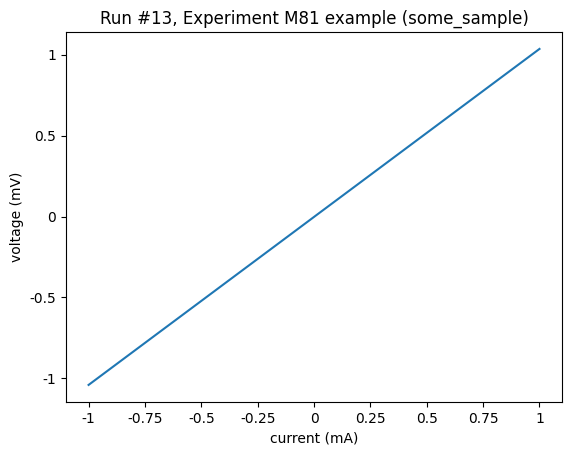

In [ ]:
meas = Measurement()

current = Parameter('current',
                    label='current',
                    unit='A')

voltage = Parameter('voltage',
                         label='voltage',
                         unit='V')

meas.register_parameter(current)
meas.register_parameter(voltage, setpoints=[current])

M81.S1.output_on()

with meas.run() as datasaver:
    meas_guid = datasaver.dataset.guid
    print(f'GUID: {meas_guid}')

    for x in np.linspace(-0.001, 0.001, 21):
        M81.S1.current_peak_amplitude(x)
        time.sleep(0.5)

        # read parameters
        curr = M81.S1.current_peak_amplitude()
        volt = M81.M1.read_DC()


        datasaver.add_result((current, curr),
                             (voltage, volt)
                            )

dataset = datasaver.dataset

M81.S1.output_off()
plot_dataset(dataset)

#### Data Streaming

In [4]:
rate = 100
num_points = 2**8

data = M81.stream_data(rate, num_points, ('RTIMe',1),('SAMPlitude',1),('MDC',1), transpose_data=True)

Streaming...
Buffered points: 256         
All data collected.


In [ ]:
meas = Measurement()

timestamp = Parameter('timestamp',
                    label='timestamp',
                    unit='s')

current = Parameter('current',
                    label='current',
                    unit='A')

voltage = Parameter('voltage',
                         label='voltage',
                         unit='V')

meas.register_parameter(timestamp)
meas.register_parameter(current, setpoints=[timestamp])
meas.register_parameter(voltage, setpoints=[timestamp])

M81.S1.output_on()

with meas.run() as datasaver:
    try:
        data = M81.stream_data(rate, num_points, ('RTIMe',1),('SAMPlitude',1),('MDC',1))

        print('Saving data...')
        for i in range(0, len(data[0]), 1):

            # read parameters
            t = data[0][int(i)]
            i = data[1][int(i)]
            v = data[2][int(i)]


            # add data to measurement table
            datasaver.add_result((timestamp, t),
                                 (current, i),
                                 (voltage, v),
                                 )
    except Exception as err:
        log.critical(err)
        print(f'Error: {err}')

dataset = datasaver.dataset
print('Data saved.')

M81.S1.output_off()

Starting experimental run with id: 18. 
Streaming...
Finished Streaming
All data collected.
Saving data...
Data saved.


### Close connection to M81

In [5]:
M81.close()

Connection closed to M81.
